In [131]:
import torch
from torch import nn, Tensor
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

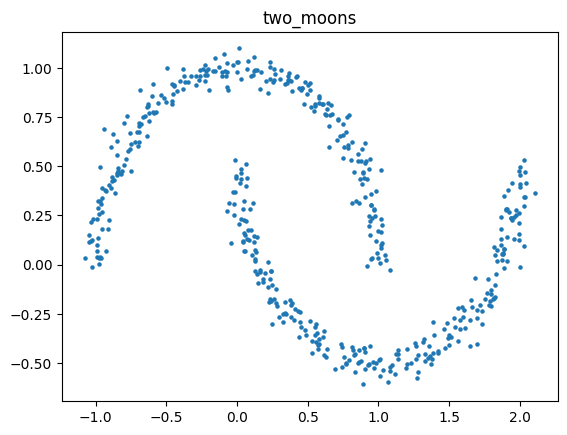

In [132]:
data = make_moons(512, noise=0.05, random_state=42)[0]
plt.scatter(data[:,0], data[:,1], s=5)
plt.title("two_moons")
plt.show()

# Model

In [135]:
class Rectified_flow(nn.Module):
    def __init__(self, dim = 2, h = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim)
        )
    
    def forward(self, t, x_t):
        x_t_t = torch.concat([x_t, t], dim=-1)
        res = self.net(x_t_t)
        return res
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        # mid-point ODE solver here for simplicity
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t= x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)

# Training

In [136]:
model = Rectified_flow(dim=2, h=64).to(device=DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
epoch = 20000

for _ in tqdm(range(epoch)):
    x_1 = Tensor(make_moons(512, noise=0.05)[0]).to(device=DEVICE)
    x_0 = torch.randn_like(x_1).to(device=DEVICE)
    t = torch.rand(len(x_1), 1).to(device=DEVICE)

    x_t = t*x_1 + (1 - t)*x_0
    dx_t = x_1 - x_0

    optimizer.zero_grad()
    loss = loss_fn(model(t=t, x_t=x_t), dx_t)
    loss.backward()
    optimizer.step()

100%|██████████| 20000/20000 [00:28<00:00, 709.57it/s]


# Sampling

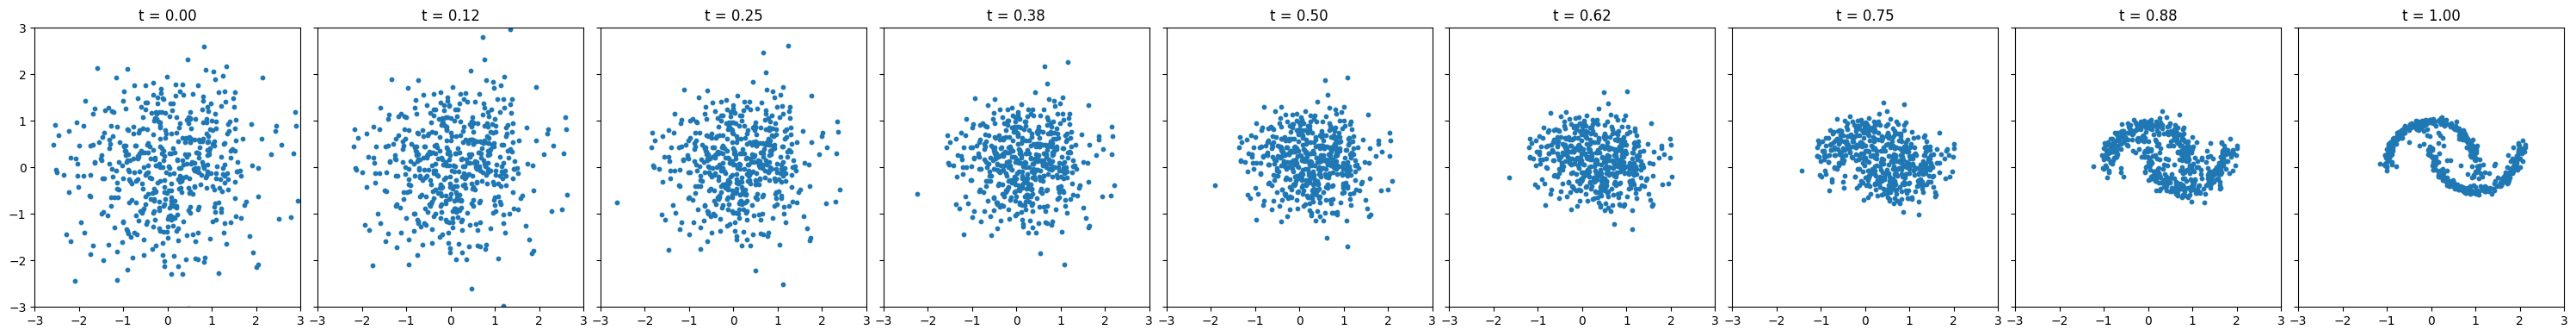

In [159]:
x = torch.randn(512, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1).to(device=DEVICE)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = x.to(device=DEVICE)
    x = model.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1]) # solve ODE
    x = x.to(torch.device('cpu'))
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()

In [99]:
x = torch.randn(500, 2)
n_steps = 8
time_steps = torch.linspace(0, 1.0, n_steps + 1)

for i in range(n_steps):
    x = model.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1]) # solve ODE

# Flow Compressor

## estimated g model

In [142]:
class residual_block(nn.Module):
    def __init__(self, dim=2, h=64):
        super().__init__()
        self.layer_block = nn.Sequential(
            nn.Linear(dim, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim)
        )
        self.out_act = nn.ELU()
    
    def forward(self, x):
        return self.out_act(x + self.layer_block(x))


In [143]:
class flow_compressor(nn.Module):
    def __init__(self, dim = 2, h = 64, block = 1):
        super().__init__()
        self.net = nn.ModuleList()
        
        for _ in range(block):
            self.net.append(residual_block(dim=dim,h=h))

        self.block = block
    
    def forward(self, x_0):
        x = x_0
        for i in range(len(self.net)):
            x = self.net[i](x)
            
        return x
    
    def sample(self, x):
        x = x_0
        for i in range(len(self.net)):
            x = self.net[i](x)
            
        return x


## Training

In [144]:
compressor = flow_compressor(dim=2, h=64, block=1).to(device=DEVICE)
flow_compressor_loss_fn = nn.MSELoss()
flow_compressor_optimizer = torch.optim.Adam(compressor.parameters(), lr = 0.001)
epoch = 20000

n_steps = 8
time_steps = torch.linspace(0, 1.0, n_steps + 1).to(device=DEVICE)
for _ in tqdm(range(epoch)):
    x_0 = torch.randn(512, 2).to(device=DEVICE)
    x_1 = x_0.clone().to(device=DEVICE)
    for i in range(n_steps):
        x_1 = model.step(x_t=x_1, t_start=time_steps[i], t_end=time_steps[i + 1]) # solve ODE

    flow_compressor_optimizer.zero_grad()
    loss = flow_compressor_loss_fn(compressor(x_0), x_1)
    loss.backward()
    flow_compressor_optimizer.step()
    


100%|██████████| 20000/20000 [03:30<00:00, 95.04it/s] 


## Sampling

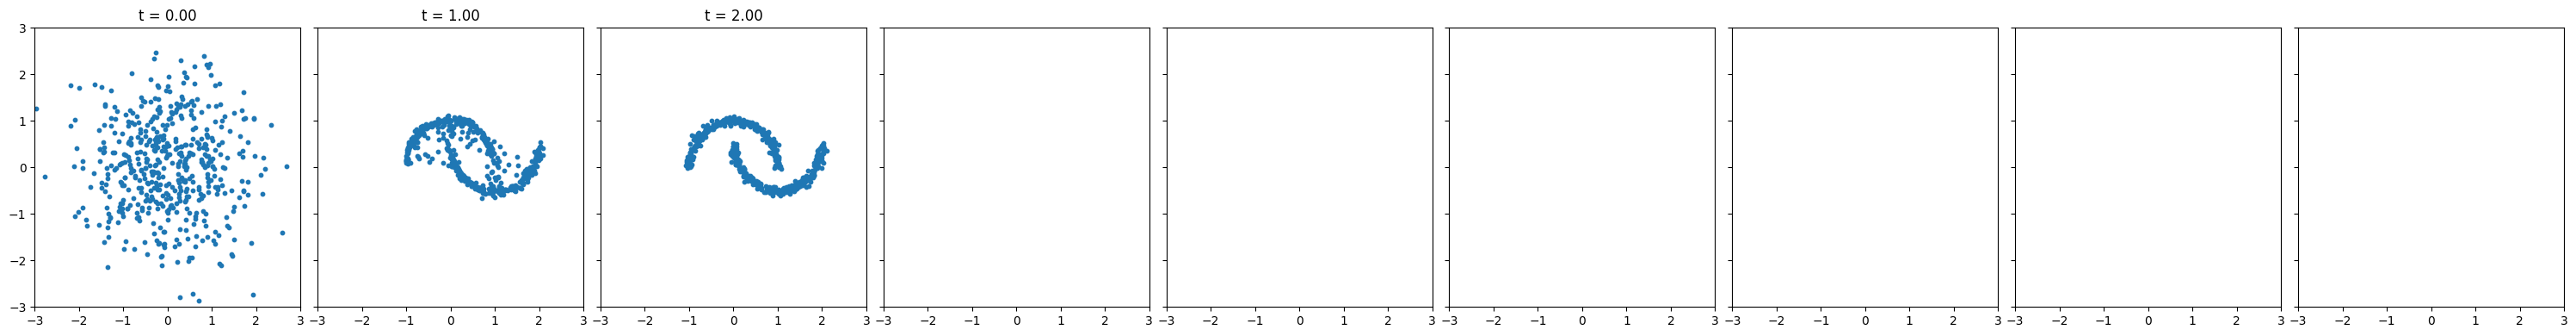

In [155]:
x_0 = torch.randn(512, 2)

fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)

axes[0].scatter(x_0.detach()[:, 0], x_0.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

x_0 = x_0.to(device=DEVICE)
x = compressor.sample(x_0).to(device=torch.device('cpu')) # solve ODE
axes[1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[1].set_title(f't = {1:.2f}')

data = make_moons(512, noise=0.05, random_state=42)[0]
axes[2].scatter(data[:, 0], data[:, 1], s=10)
axes[2].set_title(f't = {2:.2f}')
plt.tight_layout()
plt.show()

In [91]:
x_0 = torch.randn(512, 2)
x = compressor.sample(x_0) # solve ODE